# AUEB M.Sc. in Data Science (part-time)

### 2024.04 - 2024.06

Exercise 10

**Course**: Text Analytics   
**Authors**:
Anagnos Theodoros (p3352323) -
Michalopoulos Ioannis (p3352314) -
Kafantaris Panagiotis (p3352328) -  
Vigkos Ioannis (p3352326)

**Date**: 2024-04-29

installing libraries

In [ ]:
!pip install --upgrade tensorflow

In [2]:
!pip install conllu

download dataset

In [3]:
# !wget https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-train.conllu -O en_ewt_train.conllu
!wget https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-dev.conllu -O en_ewt_dev.conllu
# !wget https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-test.conllu -O en_ewt_test.conllu

--2024-05-16 08:14:20--  https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-dev.conllu
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu [following]
--2024-05-16 08:14:21--  https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1764449 (1.7M) [text/plain]
Saving to: ‘en_ewt_dev.conllu’

en_ewt_dev.conllu   100%[===================>]   1.68M  --.-KB/s    in 0.06s   

2024-05-16 08:14:21 (29.4 MB/s) - ‘en_ewt_dev.conll

we tokenize the sentences and build the lists accordingly. We seperate words from tags into different variables for every subset

In [4]:
from conllu import parse

def parse_conllu(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = f.read()
        sentences = parse(data)
    return sentences

def extract_words_and_tags(sentences):
    words = []
    tags = []
    for sentence in sentences: # we loop in each sentene
        for token in sentence: # we loop in each token/word
            if token['form'] and token['upostag']:
                words.append(token['form']) # we take the word
                tags.append(token['upostag']) # we take the tag
    return words, tags

# train_sentences = parse_conllu("en_ewt_train.conllu")
# train_words, train_tags = extract_words_and_tags(train_sentences)
train_sentences = parse_conllu("en_ewt_dev.conllu")
train_words, train_tags = extract_words_and_tags(train_sentences)

# dev_sentences = parse_conllu("en_ewt_dev.conllu")
# dev_words, dev_tags = extract_words_and_tags(dev_sentences)

# test_sentences = parse_conllu("en_ewt_test.conllu")
# test_words, test_tags = extract_words_and_tags(test_sentences)

#reduce the number of data for time restrictions...

from sklearn.model_selection import train_test_split

# Split data (60-20-20)
train_words, temp_sentences, train_tags, temp_tags = train_test_split(train_words, train_tags, test_size=0.4, random_state=42)
dev_words, test_words, dev_tags, test_tags = train_test_split(temp_sentences, temp_tags, test_size=0.5, random_state=42)

In [5]:
len(train_words), len(dev_words), len(test_words)

(15307, 5102, 5103)

we make sure everything is in lower case

In [6]:
train_words = [word.lower() for word in train_words]
dev_words = [word.lower() for word in dev_words]
test_words = [word.lower() for word in test_words]

example

In [7]:
print(train_words[:10])
print(train_tags[:10])

['make', 'when', 'by', 'which', 'from', 'palestinian', 'landed', 'the', 'and', 'reports']
['VERB', 'ADV', 'ADP', 'DET', 'ADP', 'ADJ', 'VERB', 'DET', 'CCONJ', 'VERB']


we download the embendings

In [12]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


we map each word with its embending matrix. We do the same for every subset. We initialize with zeros, each words that isnt included in the vocabulary (wv)

In [13]:
import numpy as np

# Function to map words to embeddings
def map_words_to_embeddings(words, wv):
    embeddings = []
    for word in words:
        if word in wv:
            embeddings.append(wv[word])
        else:
            # Handle out-of-vocabulary (OOV) words by initializing with zeros
            embeddings.append(np.zeros(wv.vector_size))
    return np.array(embeddings)

# Map words to embeddings for training, development, and test data
train_embeddings = map_words_to_embeddings(train_words, wv)
dev_embeddings = map_words_to_embeddings(dev_words, wv)
test_embeddings = map_words_to_embeddings(test_words, wv)

we build the one-hot encoding for each subset in order to use it as a feature in our model later.

In [19]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Encode POS tags
label_encoder = LabelEncoder()
train_tags_encoded = label_encoder.fit_transform(train_tags)
dev_tags_encoded = label_encoder.transform(dev_tags)
test_tags_encoded = label_encoder.transform(test_tags)

# Convert encoded labels to one-hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
train_tags_encoded = onehot_encoder.fit_transform(train_tags_encoded.reshape(-1, 1))
dev_tags_encoded = onehot_encoder.transform(dev_tags_encoded.reshape(-1, 1))
test_tags_encoded = onehot_encoder.transform(test_tags_encoded.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


we define our mlp model. The architecture was determined by running the code multiple times and observing the results (Hyperparameter tuning). We set EarlyStopping to patience=3. Which means that after 3 epochs that validation loss will be worse the process will stop and will save the best weights (restore_best_weights=True)

!!!! exei mpei kwdikas se sxolia gia na trexoun grhgora ta upoloipa kai na mporesoun na ginoun debug alla kanonika prepei to teliko na to trexoume mia fora kai meta na to kanoume save.

In [25]:
# import tensorflow as tf
# from sklearn.metrics import classification_report
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Embedding, Flatten
# from keras.layers import Dropout, BatchNormalization
# from keras.callbacks import EarlyStopping
# from tensorflow.keras import Input
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import CategoricalAccuracy
# # vocab_size = len(wv) # afto den einai sosto, einai to len toy W2V, oxi tou Vocabulary

# max_sequence_length = 3

# embedding_size = 50

# model = Sequential([
#     # Embedding(input_dim=wv.vector_size, output_dim=50, input_length=max_sequence_length),  # Embedding layer
#     # Flatten(), #   to xw balei se sxolia gia na trexei grhgora to modelo alla kanonika prepei na mpei
#     Dense(256, input_dim=wv.vector_size, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(128, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(len(set(train_tags)), activation='softmax')  # Output layer with softmax activation for multi-class classification
# ])

# # model.build(input_shape=(None, max_sequence_length))

# # inp = Input(shape=(train_embeddings.shape[1],))
# # x = Dense(1024, activation='relu')(inp)
# # x = Dropout(0.3)(x)
# # x = Dense(1024, activation='relu')(x)
# # x = Dropout(0.3)(x)
# # x = Dense(512, activation='relu')(x)
# # x = Dropout(0.3)(x)
# # out = Dense(len(set(train_tags)), activation='softmax')(x)

# # model = tf.keras.Model(inputs=inp, outputs=out)

# print(model.summary())

# # Compile the model
# # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),
#                   metrics=[CategoricalAccuracy()])

# # Define early stopping callback
# # early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# early_stopping = EarlyStopping(
#     patience=10, verbose=2, restore_best_weights=True, monitor='val_f1',
#     mode='max'
# )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               77056     
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_5 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 128)              

Custom Keras callback for calculating f1, precision, recall at the end of each epoch

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report, precision_recall_curve, auc, f1_score, recall_score, precision_score

model = Sequential([
    Dense(256, input_dim=wv.vector_size, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(set(train_tags)), activation='softmax')  # Output layer with softmax activation for multi-class classification
])

print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[CategoricalAccuracy()])

class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        val_targ = tf.cast(val_targ, dtype=tf.float32)
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)

        _val_f1 = f1_score(val_targ, val_predict, average="weighted")
        _val_recall = recall_score(val_targ, val_predict, average="weighted")
        _val_precision = precision_score(val_targ, val_predict, average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(f" — val_f1: {_val_f1} — val_precision: {_val_precision} — val_recall: {_val_recall}")
        return

early_stopping = EarlyStopping(patience=10, verbose=2, restore_best_weights=True, monitor='val_loss', mode='min')

history = model.fit(train_embeddings, train_tags_encoded, validation_data=(dev_embeddings, dev_tags_encoded),
                    batch_size=256, epochs=100, shuffle=True,
                    callbacks=[Metrics(valid_data=(dev_embeddings, dev_tags_encoded)), early_stopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               77056     
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 128)              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 6ms/step
 — val_f1: 0.5396444102746824 — val_precision: 0.6220950888912166 — val_recall: 0.5817326538612309
60/60 [==============================] - 4s 71ms/step - loss: 1.1817 - categorical_accuracy: 0.6769 - val_loss: 1.8519 - val_categorical_accuracy: 0.5817 - val_f1: 0.5396 - val_recall: 0.5817 - val_precision: 0.6221
Epoch 3/100
 3/60 [>.............................] - ETA: 1s - loss: 1.1075 - categorical_accuracy: 0.6979

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 0s 2ms/step
 — val_f1: 0.6646549294367046 — val_precision: 0.7581660466379031 — val_recall: 0.697765582124657
60/60 [==============================] - 2s 33ms/step - loss: 1.0244 - categorical_accuracy: 0.7161 - val_loss: 1.5405 - val_categorical_accuracy: 0.6978 - val_f1: 0.6647 - val_recall: 0.6978 - val_precision: 0.7582
Epoch 4/100
17/60 [=======>......................] - ETA: 0s - loss: 0.9849 - categorical_accuracy: 0.7268

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 0s 3ms/step
 — val_f1: 0.7055782954084493 — val_precision: 0.8004245301859101 — val_recall: 0.7261858094864759
60/60 [==============================] - 1s 23ms/step - loss: 0.9359 - categorical_accuracy: 0.7406 - val_loss: 1.2916 - val_categorical_accuracy: 0.7262 - val_f1: 0.7056 - val_recall: 0.7262 - val_precision: 0.8004
Epoch 5/100
15/60 [======>.......................] - ETA: 0s - loss: 0.8954 - categorical_accuracy: 0.7440

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 0s 3ms/step
 — val_f1: 0.7362187767599067 — val_precision: 0.8090200536031256 — val_recall: 0.7485299882399059
60/60 [==============================] - 2s 26ms/step - loss: 0.8855 - categorical_accuracy: 0.7486 - val_loss: 1.0710 - val_categorical_accuracy: 0.7485 - val_f1: 0.7362 - val_recall: 0.7485 - val_precision: 0.8090
Epoch 6/100
15/60 [======>.......................] - ETA: 0s - loss: 0.8648 - categorical_accuracy: 0.7604

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 0s 3ms/step
 — val_f1: 0.754297704589821 — val_precision: 0.8201877144909695 — val_recall: 0.7653861230889847
60/60 [==============================] - 2s 27ms/step - loss: 0.8490 - categorical_accuracy: 0.7603 - val_loss: 0.9145 - val_categorical_accuracy: 0.7654 - val_f1: 0.7543 - val_recall: 0.7654 - val_precision: 0.8202
Epoch 7/100
17/60 [=======>......................] - ETA: 0s - loss: 0.8114 - categorical_accuracy: 0.7668

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 0s 2ms/step
 — val_f1: 0.7657525911840981 — val_precision: 0.8227570415053881 — val_recall: 0.773030184241474
60/60 [==============================] - 1s 22ms/step - loss: 0.8288 - categorical_accuracy: 0.7646 - val_loss: 0.8112 - val_categorical_accuracy: 0.7730 - val_f1: 0.7658 - val_recall: 0.7730 - val_precision: 0.8228
Epoch 8/100
15/60 [======>.......................] - ETA: 0s - loss: 0.7870 - categorical_accuracy: 0.7719

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 0s 3ms/step
 — val_f1: 0.7759402657473853 — val_precision: 0.834905637157906 — val_recall: 0.7834182673461387
60/60 [==============================] - 2s 26ms/step - loss: 0.7988 - categorical_accuracy: 0.7712 - val_loss: 0.7615 - val_categorical_accuracy: 0.7834 - val_f1: 0.7759 - val_recall: 0.7834 - val_precision: 0.8349
Epoch 9/100
11/60 [====>.........................] - ETA: 0s - loss: 0.7416 - categorical_accuracy: 0.7866

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 3ms/step
 — val_f1: 0.779634191958786 — val_precision: 0.8338703370620327 — val_recall: 0.7840062720501764
60/60 [==============================] - 2s 26ms/step - loss: 0.7923 - categorical_accuracy: 0.7714 - val_loss: 0.7390 - val_categorical_accuracy: 0.7840 - val_f1: 0.7796 - val_recall: 0.7840 - val_precision: 0.8339
Epoch 10/100
16/60 [=======>......................] - ETA: 0s - loss: 0.7810 - categorical_accuracy: 0.7729

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 3ms/step
 — val_f1: 0.7793176361880254 — val_precision: 0.8345696448843928 — val_recall: 0.7859662877303019
60/60 [==============================] - 2s 42ms/step - loss: 0.7735 - categorical_accuracy: 0.7767 - val_loss: 0.7300 - val_categorical_accuracy: 0.7860 - val_f1: 0.7793 - val_recall: 0.7860 - val_precision: 0.8346
Epoch 11/100
 7/60 [==>...........................] - ETA: 0s - loss: 0.7703 - categorical_accuracy: 0.7645

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 0s 2ms/step
 — val_f1: 0.7830152088405389 — val_precision: 0.8353302169297516 — val_recall: 0.786750294002352
60/60 [==============================] - 2s 29ms/step - loss: 0.7635 - categorical_accuracy: 0.7761 - val_loss: 0.7300 - val_categorical_accuracy: 0.7868 - val_f1: 0.7830 - val_recall: 0.7868 - val_precision: 0.8353
Epoch 12/100
18/60 [========>.....................] - ETA: 0s - loss: 0.7415 - categorical_accuracy: 0.7823

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 0s 2ms/step
 — val_f1: 0.7821249273642453 — val_precision: 0.8367828462797529 — val_recall: 0.7877303018424148
60/60 [==============================] - 1s 20ms/step - loss: 0.7542 - categorical_accuracy: 0.7808 - val_loss: 0.7297 - val_categorical_accuracy: 0.7877 - val_f1: 0.7821 - val_recall: 0.7877 - val_precision: 0.8368
Epoch 13/100
19/60 [========>.....................] - ETA: 0s - loss: 0.7430 - categorical_accuracy: 0.7804

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 0s 2ms/step
 — val_f1: 0.7814301537842586 — val_precision: 0.8353084530742874 — val_recall: 0.7869462955703646
60/60 [==============================] - 1s 21ms/step - loss: 0.7444 - categorical_accuracy: 0.7827 - val_loss: 0.7314 - val_categorical_accuracy: 0.7869 - val_f1: 0.7814 - val_recall: 0.7869 - val_precision: 0.8353
Epoch 14/100
15/60 [======>.......................] - ETA: 0s - loss: 0.7376 - categorical_accuracy: 0.7872

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 0s 3ms/step
 — val_f1: 0.7854386851558173 — val_precision: 0.8357035747611549 — val_recall: 0.7883183065464524
60/60 [==============================] - 2s 26ms/step - loss: 0.7382 - categorical_accuracy: 0.7855 - val_loss: 0.7290 - val_categorical_accuracy: 0.7883 - val_f1: 0.7854 - val_recall: 0.7883 - val_precision: 0.8357
Epoch 15/100
19/60 [========>.....................] - ETA: 0s - loss: 0.7047 - categorical_accuracy: 0.7981

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 0s 2ms/step
 — val_f1: 0.7842525665978303 — val_precision: 0.8375073494337533 — val_recall: 0.7896903175225402
60/60 [==============================] - 1s 25ms/step - loss: 0.7317 - categorical_accuracy: 0.7851 - val_loss: 0.7301 - val_categorical_accuracy: 0.7897 - val_f1: 0.7843 - val_recall: 0.7897 - val_precision: 0.8375
Epoch 16/100
14/60 [======>.......................] - ETA: 0s - loss: 0.6990 - categorical_accuracy: 0.7916

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 0s 2ms/step
 — val_f1: 0.7858498931784283 — val_precision: 0.8368982649512364 — val_recall: 0.7904743237945904
60/60 [==============================] - 2s 27ms/step - loss: 0.7212 - categorical_accuracy: 0.7880 - val_loss: 0.7314 - val_categorical_accuracy: 0.7905 - val_f1: 0.7858 - val_recall: 0.7905 - val_precision: 0.8369
Epoch 17/100
14/60 [======>.......................] - ETA: 0s - loss: 0.7055 - categorical_accuracy: 0.7921

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 5ms/step
 — val_f1: 0.7878458551823 — val_precision: 0.8387697740021807 — val_recall: 0.7908663269306154
60/60 [==============================] - 3s 48ms/step - loss: 0.7199 - categorical_accuracy: 0.7881 - val_loss: 0.7286 - val_categorical_accuracy: 0.7909 - val_f1: 0.7878 - val_recall: 0.7909 - val_precision: 0.8388
Epoch 18/100
10/60 [====>.........................] - ETA: 0s - loss: 0.7285 - categorical_accuracy: 0.7828

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 5ms/step
 — val_f1: 0.7829350526105879 — val_precision: 0.8363245825998816 — val_recall: 0.7879263034104272
60/60 [==============================] - 3s 49ms/step - loss: 0.7145 - categorical_accuracy: 0.7881 - val_loss: 0.7337 - val_categorical_accuracy: 0.7879 - val_f1: 0.7829 - val_recall: 0.7879 - val_precision: 0.8363
Epoch 19/100
160/160 [==============================] - 1s 3ms/step
 — val_f1: 0.7850160251066497 — val_precision: 0.8384821903426483 — val_recall: 0.7883183065464524
60/60 [==============================] - 2s 34ms/step - loss: 0.6979 - categorical_accuracy: 0.7926 - val_loss: 0.7368 - val_categorical_accuracy: 0.7883 - val_f1: 0.7850 - val_recall: 0.7883 - val_precision: 0.8385
Epoch 20/100
160/160 [==============================] - 0s 2ms/step
 — val_f1: 0.7850153586689099 — val_precision: 0.835789244709348 — val_recall: 0.7881223049784398
60/60 [==============================] - 1s 23ms/step - loss: 0.6980 - categorica

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 1s 3ms/step
 — val_f1: 0.7854610625559335 — val_precision: 0.83751625743448 — val_recall: 0.7898863190905527
60/60 [==============================] - 1s 24ms/step - loss: 0.6877 - categorical_accuracy: 0.7950 - val_loss: 0.7383 - val_categorical_accuracy: 0.7899 - val_f1: 0.7855 - val_recall: 0.7899 - val_precision: 0.8375
Epoch 22/100
160/160 [==============================] - 0s 2ms/step
 — val_f1: 0.7822700109203087 — val_precision: 0.832447858478177 — val_recall: 0.7873382987063896
60/60 [==============================] - 1s 23ms/step - loss: 0.6945 - categorical_accuracy: 0.7938 - val_loss: 0.7375 - val_categorical_accuracy: 0.7873 - val_f1: 0.7823 - val_recall: 0.7873 - val_precision: 0.8324
Epoch 23/100
14/60 [======>.......................] - ETA: 0s - loss: 0.6771 - categorical_accuracy: 0.8069

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 0s 3ms/step
 — val_f1: 0.7845845686850599 — val_precision: 0.8352576910879295 — val_recall: 0.7871422971383771
60/60 [==============================] - 1s 25ms/step - loss: 0.6872 - categorical_accuracy: 0.7970 - val_loss: 0.7362 - val_categorical_accuracy: 0.7871 - val_f1: 0.7846 - val_recall: 0.7871 - val_precision: 0.8353
Epoch 24/100
16/60 [=======>......................] - ETA: 0s - loss: 0.6836 - categorical_accuracy: 0.7961

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 0s 2ms/step
 — val_f1: 0.7856194792628909 — val_precision: 0.833978300992655 — val_recall: 0.7894943159545277
60/60 [==============================] - 1s 22ms/step - loss: 0.6862 - categorical_accuracy: 0.7958 - val_loss: 0.7339 - val_categorical_accuracy: 0.7895 - val_f1: 0.7856 - val_recall: 0.7895 - val_precision: 0.8340
Epoch 25/100
17/60 [=======>......................] - ETA: 0s - loss: 0.6622 - categorical_accuracy: 0.8022

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 0s 2ms/step
 — val_f1: 0.7821989014097903 — val_precision: 0.8323574208465554 — val_recall: 0.786750294002352
60/60 [==============================] - 1s 22ms/step - loss: 0.6771 - categorical_accuracy: 0.7978 - val_loss: 0.7390 - val_categorical_accuracy: 0.7868 - val_f1: 0.7822 - val_recall: 0.7868 - val_precision: 0.8324
Epoch 26/100
18/60 [========>.....................] - ETA: 0s - loss: 0.6708 - categorical_accuracy: 0.8012

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 0s 3ms/step
 — val_f1: 0.7865600837240566 — val_precision: 0.8363697282485044 — val_recall: 0.7887103096824775
60/60 [==============================] - 2s 25ms/step - loss: 0.6758 - categorical_accuracy: 0.7994 - val_loss: 0.7401 - val_categorical_accuracy: 0.7887 - val_f1: 0.7866 - val_recall: 0.7887 - val_precision: 0.8364
Epoch 27/100
160/160 [==============================] - 1s 4ms/step
 — val_f1: 0.7852416735148304 — val_precision: 0.836851187967739 — val_recall: 0.7871422971383771
Restoring model weights from the end of the best epoch: 17.
60/60 [==============================] - 3s 43ms/step - loss: 0.6726 - categorical_accuracy: 0.7994 - val_loss: 0.7428 - val_categorical_accuracy: 0.7871 - val_f1: 0.7852 - val_recall: 0.7871 - val_precision: 0.8369
Epoch 27: early stopping


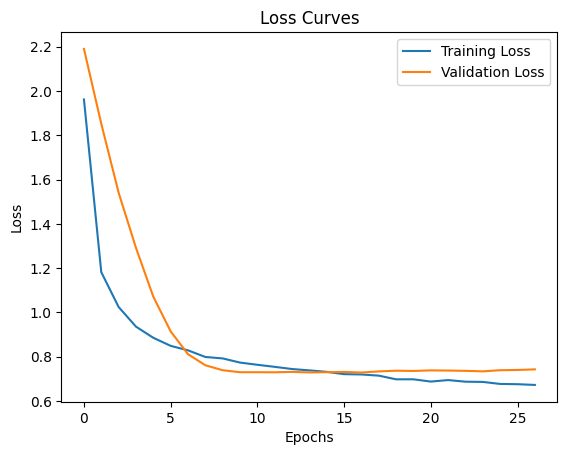

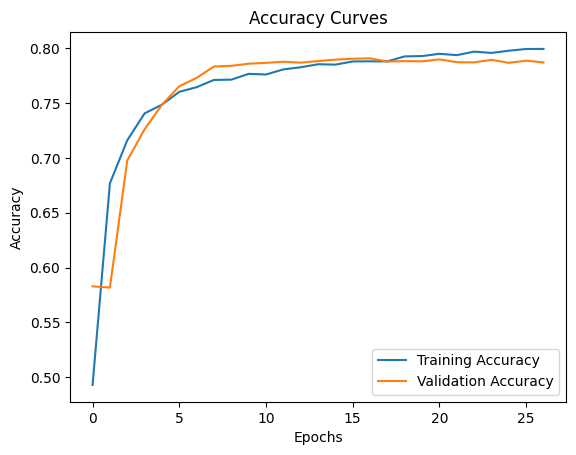

In [17]:
# Plot loss curves
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Save accuracy plots
plt.figure()
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.savefig('accuracy_plot.png')
plt.show()

## Hyper-parameter tuning

In [20]:
!pip install -U keras-tuner

from keras_tuner import RandomSearch, Objective

def build_tunable_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=128, max_value=512, step=64),
                        activation=hp.Choice('activation_' + str(i), values=['relu', 'tanh']),
                        input_dim=wv.vector_size if i == 0 else None))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Choice('dropout_' + str(i), values=[0.1, 0.5])))

    model.add(Dense(len(set(train_tags)), activation='softmax'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
                  loss='categorical_crossentropy', metrics=[CategoricalAccuracy()])
    return model

tuner = RandomSearch(build_tunable_model, objective=Objective("val_categorical_accuracy", direction="max"),
                     max_trials=10, executions_per_trial=1, directory='KT_dir', project_name='KT_tuning')

tuner.search_space_summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=2)

tuner.search(train_embeddings, train_tags_encoded, epochs=80, validation_data=(dev_embeddings, dev_tags_encoded),
             callbacks=[early_stopping])

best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(test_embeddings, test_tags_encoded)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

best_model.save("MLP_centroids.keras")

Reloading Tuner from KT_dir/KT_tuning/tuner0.json
Search space summary
Default search space size: 17
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_0 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.5], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_1 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.5], 'ordered': True}
units_2 (Int)
{'default': None, 'condit

160/160 [==============================] - 1s 4ms/step - loss: 0.7964 - categorical_accuracy: 0.7750
Test Loss: 0.7964, Test Accuracy: 0.7750


In [28]:
# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hyperparameters.values}")

Best hyperparameters: {'num_layers': 5, 'units_0': 128, 'activation_0': 'relu', 'dropout_0': 0.5, 'learning_rate': 0.001, 'units_1': 128, 'activation_1': 'tanh', 'dropout_1': 0.1, 'units_2': 512, 'activation_2': 'relu', 'dropout_2': 0.5, 'units_3': 128, 'activation_3': 'relu', 'dropout_3': 0.5, 'units_4': 128, 'activation_4': 'relu', 'dropout_4': 0.1}


In [26]:
# import tensorflow as tf
# from sklearn.metrics import f1_score, recall_score, precision_score
# import numpy as np
# import os


# class Metrics(tf.keras.callbacks.Callback):
#     def __init__(self, valid_data):
#         super(Metrics, self).__init__()
#         self.validation_data = valid_data

#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
#         val_targ = self.validation_data[1]
#         val_targ = tf.cast(val_targ,dtype=tf.float32)
#         # If val_targ is 1-hot
#         if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
#           val_targ = np.argmax(val_targ, -1)

#         _val_f1 = f1_score(val_targ, val_predict,average="weighted")
#         _val_recall = recall_score(val_targ, val_predict,average="weighted")
#         _val_precision = precision_score(val_targ, val_predict,average="weighted")

#         logs['val_f1'] = _val_f1
#         logs['val_recall'] = _val_recall
#         logs['val_precision'] = _val_precision
#         print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
#         return

Train the model. We fit the embendings and 1-hot encoded tags

In [21]:
# # Train the model with early stopping
# # history = model.fit(train_embeddings, train_tags_encoded, epochs=15, batch_size=32, validation_data=(dev_embeddings, dev_tags_encoded), callbacks=[early_stopping])
# history = model.fit(train_embeddings, train_tags_encoded,
#               validation_data=(dev_embeddings, dev_tags_encoded),
#               batch_size=256,
#               epochs=100,
#               shuffle=True,
#               callbacks=[Metrics(valid_data=(dev_embeddings, dev_tags_encoded)),
#               early_stopping])


one-hot encoding for test data

In [29]:
# Encode POS tags for test data
test_tags_encoded = label_encoder.transform(test_tags)
test_tags_encoded = onehot_encoder.transform(test_tags_encoded.reshape(-1, 1))

evaluate the model

In [30]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_embeddings, test_tags_encoded)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

160/160 [==============================] - 1s 3ms/step - loss: 0.7759 - categorical_accuracy: 0.7770
Test Loss: 0.7759
Test Accuracy: 0.7770


Curves showing the loss on training and development data as a function of epochs

In [24]:
# import matplotlib.pyplot as plt

# # # Extract loss and accuracy from the history object
# # train_loss = history.history['loss']
# # dev_loss = history.history['val_loss']
# # epochs = range(1, len(train_loss) + 1)

# # # Plot loss curves
# # plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
# # plt.plot(epochs, dev_loss, 'ro-', label='Validation Loss')
# # plt.title('Training and Validation Loss')
# # plt.xlabel('Epochs')
# # plt.ylabel('Loss')
# # plt.legend()
# # plt.grid(True)
# # plt.show()
# plt.plot(history.history['categorical_accuracy'])
# plt.plot(history.history['val_categorical_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'dev'], loc='upper left')
# plt.xticks(range(1,len(history.history['categorical_accuracy'])+1,4))
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'dev'], loc='upper right')
# plt.xticks(range(1,len(history.history['loss'])+1,4))
# plt.show()

In [26]:
import numpy as np
from sklearn.metrics import classification_report, precision_recall_curve, auc, f1_score, recall_score, precision_score
from sklearn.preprocessing import label_binarize

def evaluate_model(model, X, y_true, label_encoder):
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=-1)
    y_true = np.argmax(y_true, axis=-1)

    # Decode the labels back to original tags
    y_true_tags = label_encoder.inverse_transform(y_true)
    y_pred_tags = label_encoder.inverse_transform(y_pred)

    # Print classification report
    report = classification_report(y_true_tags, y_pred_tags, output_dict=True)
    print("Classification Report:\n", classification_report(y_true_tags, y_pred_tags))

    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=np.arange(len(label_encoder.classes_)))

    # Calculate precision-recall AUC for each class
    precision = {}
    recall = {}
    pr_auc = {}
    for i, label in enumerate(label_encoder.classes_):
        precision[label], recall[label], _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
        pr_auc[label] = auc(recall[label], precision[label])

    # Calculate macro-averaged scores
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    macro_pr_auc = np.mean(list(pr_auc.values()))

    # Calculate micro-averaged scores
    micro_precision = precision_score(y_true, y_pred, average='micro')
    micro_recall = recall_score(y_true, y_pred, average='micro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')

    # Micro-averaged precision-recall AUC
    precision_micro, recall_micro, _ = precision_recall_curve(y_true_bin.ravel(), y_pred_prob.ravel())
    micro_pr_auc = auc(recall_micro, precision_micro)

    print(f"Micro-averaged Precision: {micro_precision}")
    print(f"Micro-averaged Recall: {micro_recall}")
    print(f"Micro-averaged F1-Score: {micro_f1}")
    print(f"Micro-averaged Precision-Recall AUC: {micro_pr_auc}")

    return report, macro_precision, macro_recall, macro_f1, macro_pr_auc, precision, recall, pr_auc, micro_precision, micro_recall, micro_f1, micro_pr_auc

In [27]:
# Evaluate on training set
print("Training Set Metrics:")
report_train, macro_precision_train, macro_recall_train, macro_f1_train, macro_pr_auc_train, precision_train, recall_train, pr_auc_train, micro_precision_train, micro_recall_train, micro_f1_train, micro_pr_auc_train = evaluate_model(model, train_embeddings, train_tags_encoded, label_encoder)
print(f"Training Set - Macro Precision: {macro_precision_train}, Macro Recall: {macro_recall_train}, Macro F1: {macro_f1_train}, Macro PR AUC: {macro_pr_auc_train}")
print(f"Training Set - Micro Precision: {micro_precision_train}, Micro Recall: {micro_recall_train}, Micro F1: {micro_f1_train}, Micro PR AUC: {micro_pr_auc_train}")

# Evaluate on development set
print("Development Set Metrics:")
report_dev, macro_precision_dev, macro_recall_dev, macro_f1_dev, macro_pr_auc_dev, precision_dev, recall_dev, pr_auc_dev, micro_precision_dev, micro_recall_dev, micro_f1_dev, micro_pr_auc_dev = evaluate_model(model, dev_embeddings, dev_tags_encoded, label_encoder)
print(f"Development Set - Macro Precision: {macro_precision_dev}, Macro Recall: {macro_recall_dev}, Macro F1: {macro_f1_dev}, Macro PR AUC: {macro_pr_auc_dev}")
print(f"Development Set - Micro Precision: {micro_precision_dev}, Micro Recall: {micro_recall_dev}, Micro F1: {micro_f1_dev}, Micro PR AUC: {micro_pr_auc_dev}")

# Evaluate on test set
print("Test Set Metrics:")
report_test, macro_precision_test, macro_recall_test, macro_f1_test, macro_pr_auc_test, precision_test, recall_test, pr_auc_test, micro_precision_test, micro_recall_test, micro_f1_test, micro_pr_auc_test = evaluate_model(model, test_embeddings, test_tags_encoded, label_encoder)
print(f"Test Set - Macro Precision: {macro_precision_test}, Macro Recall: {macro_recall_test}, Macro F1: {macro_f1_test}, Macro PR AUC: {macro_pr_auc_test}")
print(f"Test Set - Micro Precision: {micro_precision_test}, Micro Recall: {micro_recall_test}, Micro F1: {micro_f1_test}, Micro PR AUC: {micro_pr_auc_test}")


Training Set Metrics:
479/479 [==============================] - 3s 7ms/step
Classification Report:
               precision    recall  f1-score   support

         ADJ       0.94      0.95      0.94      1129
         ADP       0.82      0.71      0.76      1224
         ADV       0.95      0.79      0.86       757
         AUX       0.91      0.92      0.91       954
       CCONJ       0.97      0.29      0.44       481
         DET       0.94      0.70      0.80      1131
        INTJ       1.00      0.68      0.81        65
        NOUN       0.90      0.92      0.91      2541
         NUM       0.95      0.35      0.51       246
        PART       0.98      0.31      0.47       363
        PRON       0.97      0.92      0.95      1351
       PROPN       0.93      0.62      0.74      1092
       PUNCT       0.49      1.00      0.66      1844
       SCONJ       0.65      0.58      0.61       238
         SYM       1.00      0.60      0.75        50
        VERB       0.91      0.88 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Classification Report:
               precision    recall  f1-score   support

         ADJ       0.90      0.88      0.89       368
         ADP       0.83      0.70      0.76       358
         ADV       0.89      0.75      0.81       240
         AUX       0.87      0.89      0.88       292
       CCONJ       0.95      0.26      0.40       136
         DET       0.95      0.74      0.83       408
        INTJ       0.87      0.57      0.68        23
        NOUN       0.83      0.91      0.87       823
         NUM       0.94      0.39      0.55        74
        PART       1.00      0.34      0.50       134
        PRON       0.97      0.90      0.93       453
       PROPN       0.88      0.55      0.68       393
       PUNCT       0.51      1.00      0.68       635
       SCONJ       0.62      0.62      0.62        85
         SYM       1.00      0.31      0.48        16
        VERB       0.90      0.83      0.86       581
           X       0.00      0.00      0.00         9
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Micro-averaged Precision: 0.7908663269306154
Micro-averaged Recall: 0.7908663269306154
Micro-averaged F1-Score: 0.7908663269306154
Micro-averaged Precision-Recall AUC: 0.8603343570003978
Development Set - Macro Precision: 0.8182426648831327, Macro Recall: 0.6258285855357337, Macro F1: 0.6750945546399109, Macro PR AUC: 0.7452817373311922
Development Set - Micro Precision: 0.7908663269306154, Micro Recall: 0.7908663269306154, Micro F1: 0.7908663269306154, Micro PR AUC: 0.8603343570003978
Test Set Metrics:
160/160 [==============================] - 2s 12ms/step
Classification Report:
               precision    recall  f1-score   support

         ADJ       0.87      0.86      0.86       372
         ADP       0.87      0.70      0.77       460
         ADV       0.92      0.72      0.81       230
         AUX       0.88      0.87      0.88       321
       CCONJ       0.87      0.25      0.38       162
         DET       0.95      0.75      0.84       362
        INTJ       1.00      0.5

In [1]:
# import numpy as np
# from sklearn.metrics import classification_report, precision_recall_curve, auc, f1_score, recall_score, precision_score

# def evaluate_model(model, X, y_true, label_encoder):
#     y_pred_prob = model.predict(X)
#     y_pred = np.argmax(y_pred_prob, axis=-1)
#     y_true = np.argmax(y_true, axis=-1)

#     # Decode the labels back to original tags
#     y_true_tags = label_encoder.inverse_transform(y_true)
#     y_pred_tags = label_encoder.inverse_transform(y_pred)

#     # Print classification report
#     report = classification_report(y_true_tags, y_pred_tags, output_dict=True)
#     print("Classification Report:\n", classification_report(y_true_tags, y_pred_tags))

#     # Calculate precision-recall AUC for each class
#     precision = {}
#     recall = {}
#     pr_auc = {}
#     for i, label in enumerate(label_encoder.classes_):
#         y_true_binary = (y_true == i).astype(int)
#         y_pred_binary = y_pred_prob[:, i]
#         precision[label], recall[label], _ = precision_recall_curve(y_true_binary, y_pred_binary)
#         pr_auc[label] = auc(recall[label], precision[label])

#     # Calculate macro-averaged scores
#     macro_precision = np.mean([precision_score(y_true, y_pred, average=None)[i] for i in range(len(label_encoder.classes_))])
#     macro_recall = np.mean([recall_score(y_true, y_pred, average=None)[i] for i in range(len(label_encoder.classes_))])
#     macro_f1 = np.mean([f1_score(y_true, y_pred, average=None)[i] for i in range(len(label_encoder.classes_))])
#     macro_pr_auc = np.mean(list(pr_auc.values()))

#     return report, macro_precision, macro_recall, macro_f1, macro_pr_auc, precision, recall, pr_auc

# # Evaluate on development set
# report_dev, macro_precision_dev, macro_recall_dev, macro_f1_dev, macro_pr_auc_dev, precision_dev, recall_dev, pr_auc_dev = evaluate_model(model, dev_embeddings, dev_tags_encoded, label_encoder)
# print(f"Development Set - Macro Precision: {macro_precision_dev}, Macro Recall: {macro_recall_dev}, Macro F1: {macro_f1_dev}, Macro PR AUC: {macro_pr_auc_dev}")

# # Evaluate on test set
# report_test, macro_precision_test, macro_recall_test, macro_f1_test, macro_pr_auc_test, precision_test, recall_test, pr_auc_test = evaluate_model(model, test_embeddings, test_tags_encoded, label_encoder)
# print(f"Test Set - Macro Precision: {macro_precision_test}, Macro Recall: {macro_recall_test}, Macro F1: {macro_f1_test}, Macro PR AUC: {macro_pr_auc_test}")

In [33]:
# #Installing
# %%capture
# !pip install -U keras-tuner

In [35]:
# from keras_tuner import RandomSearch, Objective

# def build_tunable_model(hp):
#     model = Sequential()

#     # Tunable number of layers
#     for i in range(hp.Int('num_layers', 1, 3)):
#         model.add(Dense(units=hp.Int('units_' + str(i), min_value=128, max_value=512, step=64),
#                         activation=hp.Choice('activation_' + str(i), values=['relu', 'tanh']),
#                         input_dim=wv.vector_size if i == 0 else None))
#         model.add(BatchNormalization())
#         model.add(Dropout(rate=hp.Choice('dropout_' + str(i), values=[0.1, 0.2, 0.3, 0.4, 0.5])))

#     model.add(Dense(len(set(train_tags)), activation='softmax'))

#     # Compiling the model
#     model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
#                   loss='categorical_crossentropy',
#                   metrics=[CategoricalAccuracy()])

#     return model

# # Setup Hyperparameter Tuner
# tuner = RandomSearch(
#     build_tunable_model,
#     objective=Objective("val_categorical_accuracy", direction="max"),
#     max_trials=10,
#     executions_per_trial=1,
#     directory='KT_dir',
#     project_name='KT_tuning'
# )

# # Display search space summary
# tuner.search_space_summary()

# # Define Early Stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=2)

# # Start hyperparameter search
# tuner.search(train_embeddings, train_tags_encoded,
#              epochs=80,
#              validation_data=(dev_embeddings, dev_tags_encoded),
#              callbacks=[early_stopping])

# # Retrieve the best model
# best_model = tuner.get_best_models(num_models=1)[0]

# # Optional: Evaluate the best model
# loss, accuracy = best_model.evaluate(test_embeddings, test_tags_encoded)
# print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


Trial 20 Complete [00h 01m 42s]
val_categorical_accuracy: 0.7887102961540222

Best val_categorical_accuracy So Far: 0.7889063358306885
Total elapsed time: 00h 32m 42s
160/160 [==============================] - 1s 6ms/step - loss: 0.7874 - categorical_accuracy: 0.7754
Test Loss: 0.7874, Test Accuracy: 0.7754


Save the model fo future use

In [36]:
# model.save("MLP_centroids.keras")

# from tensorflow.keras.models import load_model

# #load weights and model from the saved checkpoint
# centroids_model = load_model("MLP_centroids.keras")

Precision, recall, F1, precision-recall AUC scores, for each class (tag) and classifier, separately for the training, development, and test subsets

In [37]:
# from sklearn.metrics import classification_report

# # Decode one-hot encoded test tags back to categorical labels
# test_tags_decoded = label_encoder.inverse_transform(np.argmax(test_tags_encoded, axis=1))

# # Predict POS tags for test data
# predictions = centroids_model.predict(test_embeddings)
# predicted_tags = np.argmax(predictions, axis=1)

# # Decode predicted tags back to categorical labels
# predicted_tags_decoded = label_encoder.inverse_transform(predicted_tags)

# # Print classification report
# print("Classification Report for Test Data:\n")
# print(classification_report(test_tags_decoded, predicted_tags_decoded))

160/160 [==============================] - 0s 2ms/step
Classification Report for Test Data:

              precision    recall  f1-score   support

         ADJ       0.87      0.87      0.87       372
         ADP       0.90      0.67      0.77       460
         ADV       0.91      0.71      0.80       230
         AUX       0.89      0.87      0.88       321
       CCONJ       0.87      0.25      0.38       162
         DET       0.95      0.75      0.84       362
        INTJ       0.86      0.67      0.75        27
        NOUN       0.83      0.87      0.85       852
         NUM       0.86      0.30      0.45        63
        PART       0.98      0.31      0.47       150
        PRON       0.98      0.92      0.95       418
       PROPN       0.84      0.55      0.66       381
       PUNCT       0.47      1.00      0.64       596
       SCONJ       0.61      0.70      0.65        74
         SYM       1.00      0.47      0.64        17
        VERB       0.85      0.84      0.8

we define the most frequent tags on traing dataset as well as on all tags

In [31]:
from collections import Counter

all_tags = train_tags + dev_tags + test_tags
most_frequent_tag_all = Counter(all_tags).most_common(1)[0][0]
# Calculate the most frequent tag in the training data
most_frequent_tag_training = Counter(train_tags).most_common(1)[0][0]

all_words = train_words + dev_words + test_words

In [32]:
print(most_frequent_tag_all)

NOUN


we run our baseline model

In [33]:
# Build the baseline model
baseline_tags = []
for word in test_words:
    if word in train_words:
        # If the word was encountered in the training data, tag it with the most frequent tag it had in the training data
        baseline_tags.append(most_frequent_tag_training)
    else:
        # If the word was not encountered in the training data, tag it with the most frequent tag over all words in the training data
        baseline_tags.append(most_frequent_tag_all)

example

In [34]:
baseline_tags[1000]

'NOUN'

we print its raport similarly to what we did previously for the mlp model

In [35]:
# # Evaluate the baseline model
print("Baseline Model Evaluation:")
print(classification_report(test_tags, baseline_tags))

Baseline Model Evaluation:
              precision    recall  f1-score   support

         ADJ       0.00      0.00      0.00       372
         ADP       0.00      0.00      0.00       460
         ADV       0.00      0.00      0.00       230
         AUX       0.00      0.00      0.00       321
       CCONJ       0.00      0.00      0.00       162
         DET       0.00      0.00      0.00       362
        INTJ       0.00      0.00      0.00        27
        NOUN       0.17      1.00      0.29       852
         NUM       0.00      0.00      0.00        63
        PART       0.00      0.00      0.00       150
        PRON       0.00      0.00      0.00       418
       PROPN       0.00      0.00      0.00       381
       PUNCT       0.00      0.00      0.00       596
       SCONJ       0.00      0.00      0.00        74
         SYM       0.00      0.00      0.00        17
        VERB       0.00      0.00      0.00       548
           X       0.00      0.00      0.00        11


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
